<a href="https://www.kaggle.com/code/mukaffimoin/social-media-sentiments-analysis-bert-large-cased?scriptVersionId=158444821" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
df = pd.read_csv("/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [8]:
# Assuming df is your DataFrame and 'Sentiment' is the column of interest
class_counts = df['Sentiment'].value_counts()

# Filter classes with count more than 12
selected_classes = class_counts[class_counts > 9].index

# Update df to set non-selected classes to 'Miscellaneous'
df.loc[~df['Sentiment'].isin(selected_classes), 'Sentiment'] = 'Miscellaneous'

In [9]:
df['Sentiment'].unique()

array([' Positive  ', 'Miscellaneous', ' Excitement ', ' Contentment ',
       ' Joy ', ' Neutral ', ' Happy '], dtype=object)

In [10]:
df['Sentiment'].value_counts()

Sentiment
Miscellaneous    572
 Positive         44
 Joy              42
 Excitement       32
 Contentment      14
 Neutral          14
 Happy            14
Name: count, dtype: int64

In [11]:
import pandas as pd

# Create a dictionary to map the class names to integers
class_to_int = {
" Positive  ":0,
    " Excitement ":1, 
    " Contentment ":2,
    " Joy ":3, 
    " Neutral ":4, 
    " Happy ":5,
    "Miscellaneous":6
}

# Replace the class names in the DataFrame
df['Sentiment'] = df['Sentiment'].replace(class_to_int)



In [12]:
df['Sentiment'].value_counts()

Sentiment
6    572
0     44
3     42
1     32
2     14
4     14
5     14
Name: count, dtype: int64

In [62]:
class_names = [" Positive  "," Excitement ", " Contentment "," Joy ", " Neutral ", " Happy ","Miscellaneous"]


In [14]:
# Assuming 'Sentiment' is the name of the column in your DataFrame
df1 = df[df['Sentiment'] != 6]

In [15]:
df1['Sentiment'] .value_counts()

Sentiment
0    44
3    42
1    32
2    14
4    14
5    14
Name: count, dtype: int64

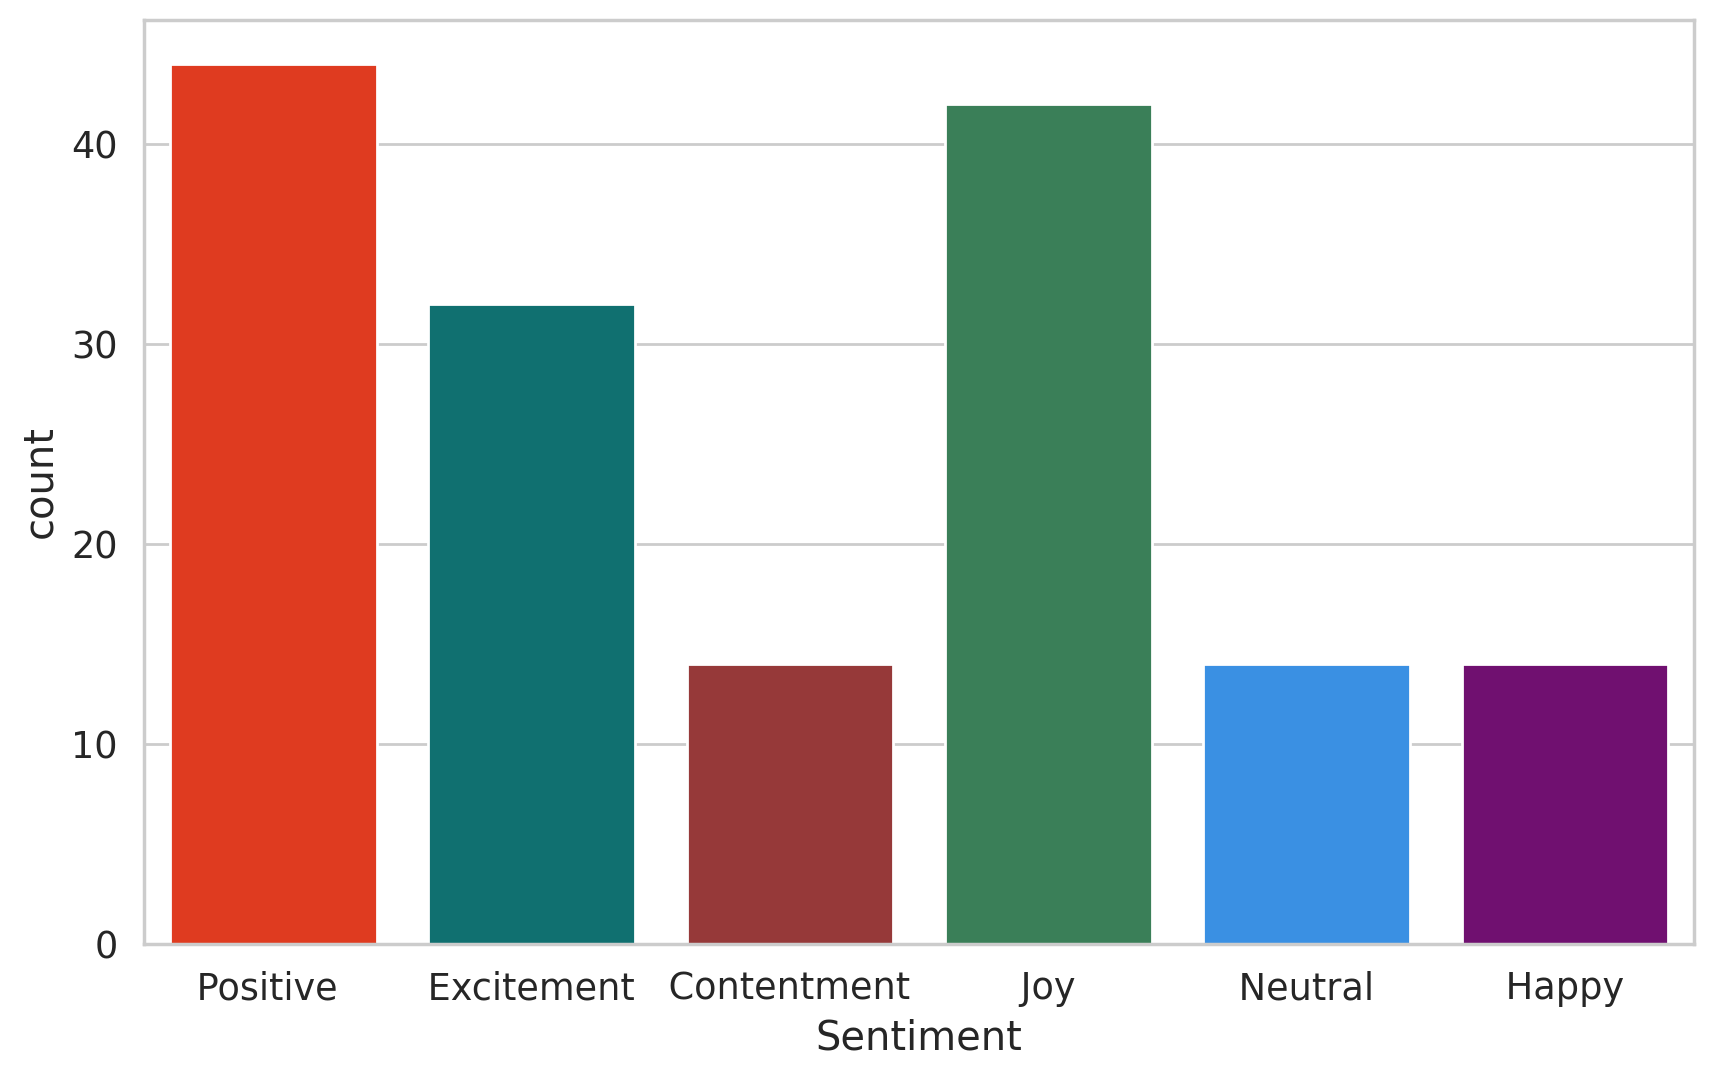

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

custom_palette = ['#FF2400', 'teal', '#A52A2A', 'Seagreen', 'Dodgerblue', 'Purple', 'Gold', 'MediumVioletRed']

sns.countplot(x='Sentiment', data=df1, palette=custom_palette)
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()


In [79]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_text_length(data, title):

    data['text_length'] = data['Text'].apply(len)

    plt.figure(figsize=(8, 4))

    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    plt.hist(data['text_length'], bins=40, color='lightcoral', edgecolor='black', alpha=0.7, label='Bangla News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')

    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Show the plot
    plt.show()




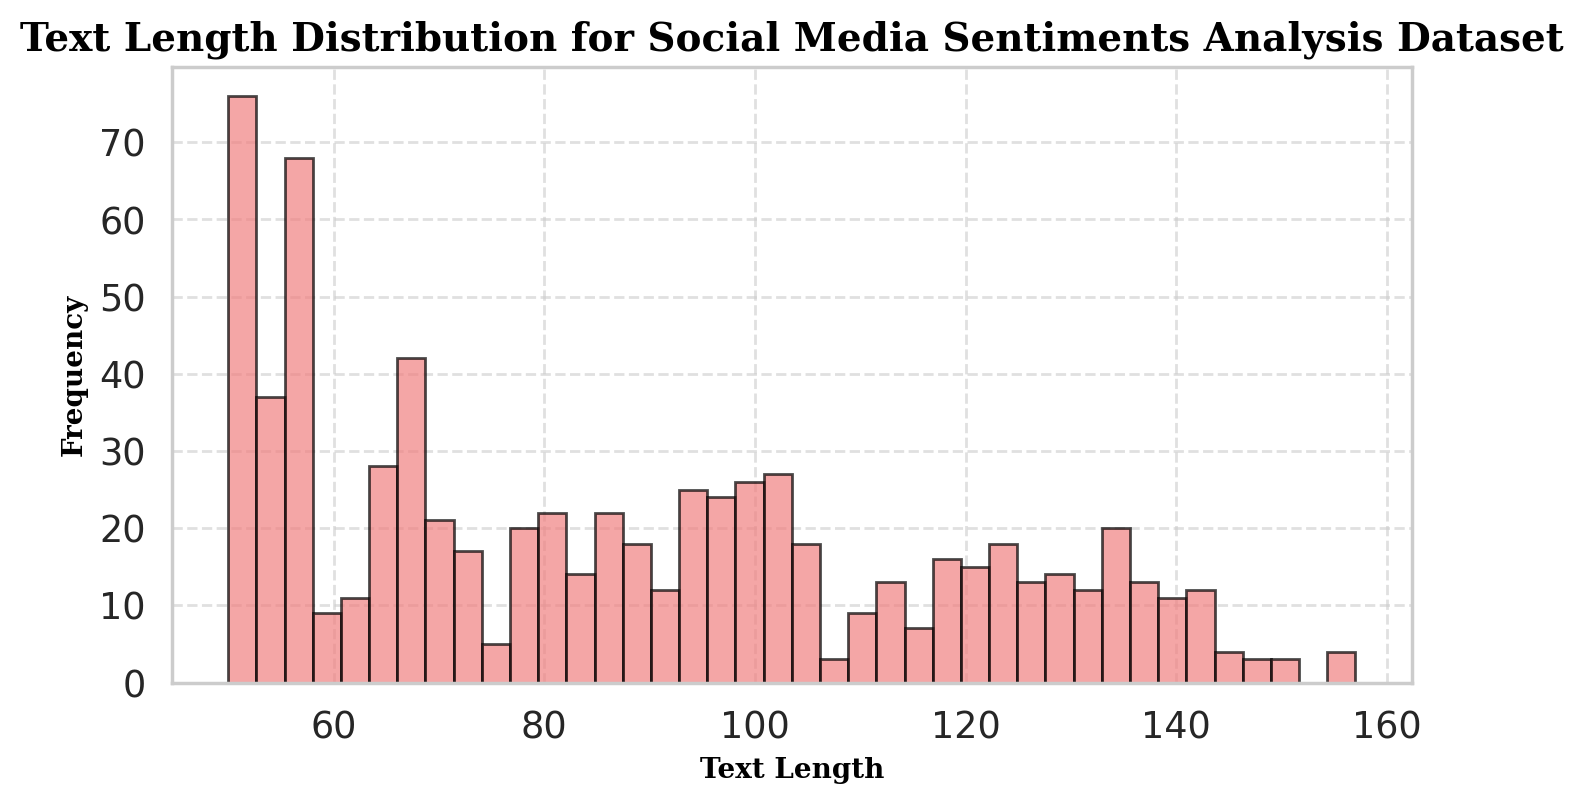

In [82]:
visualize_text_length(df, 'Social Media Sentiments Analysis Dataset')

In [88]:
from wordcloud import WordCloud

def create_wordcloud(data, column, title):
    # Specify a Bangla-supported font, such as "Siyam Rupali"



    #This setting disables the detection of collocations (multi-word phrases) to focus on individual words.
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          colormap='turbo', collocations=False).generate(' '.join(data[column]))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()

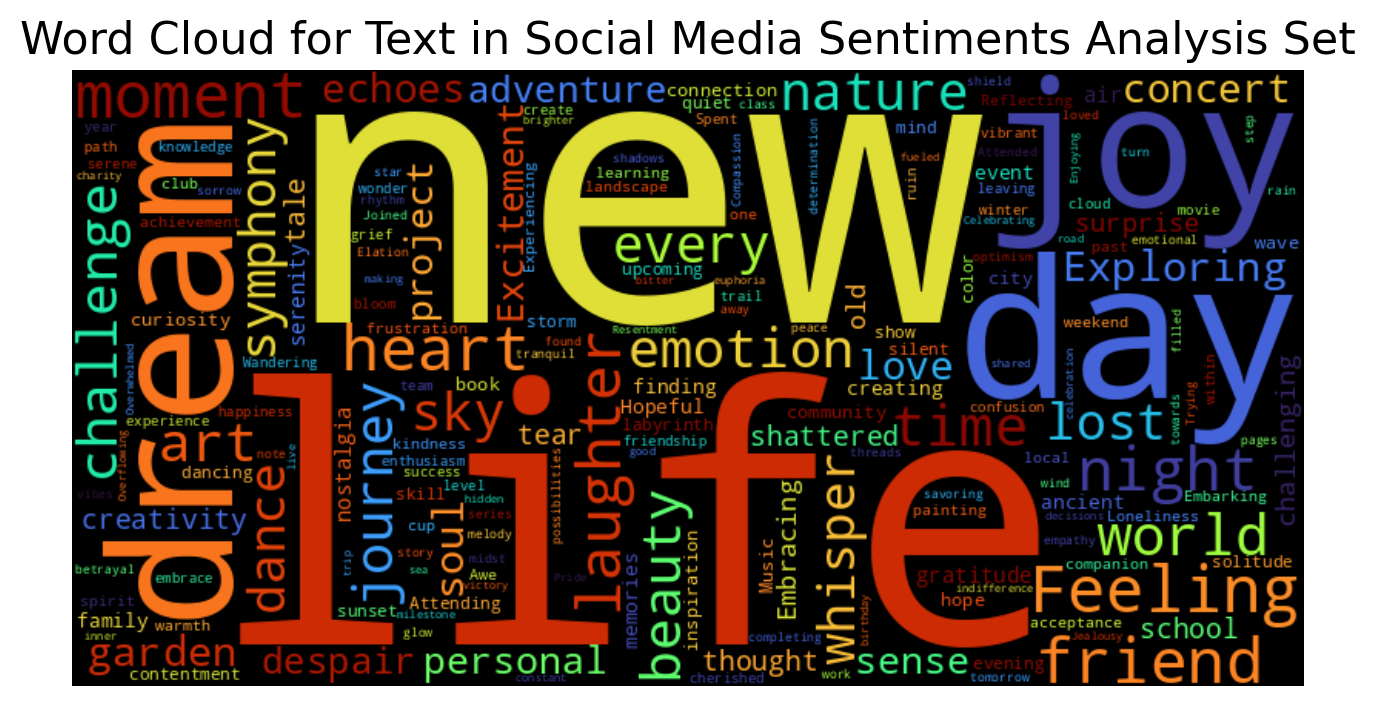

In [89]:
create_wordcloud(df, 'Text', 'Social Media Sentiments Analysis Set')

In [17]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' 

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
sample_txt = 'Enjoying a beautiful day at the park!'

In [21]:

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['En', '##joy', '##ing', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [13832, 18734, 1158, 170, 2712, 1285, 1120, 1103, 2493, 106]


In [22]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
token_lens = []

for txt in df.Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


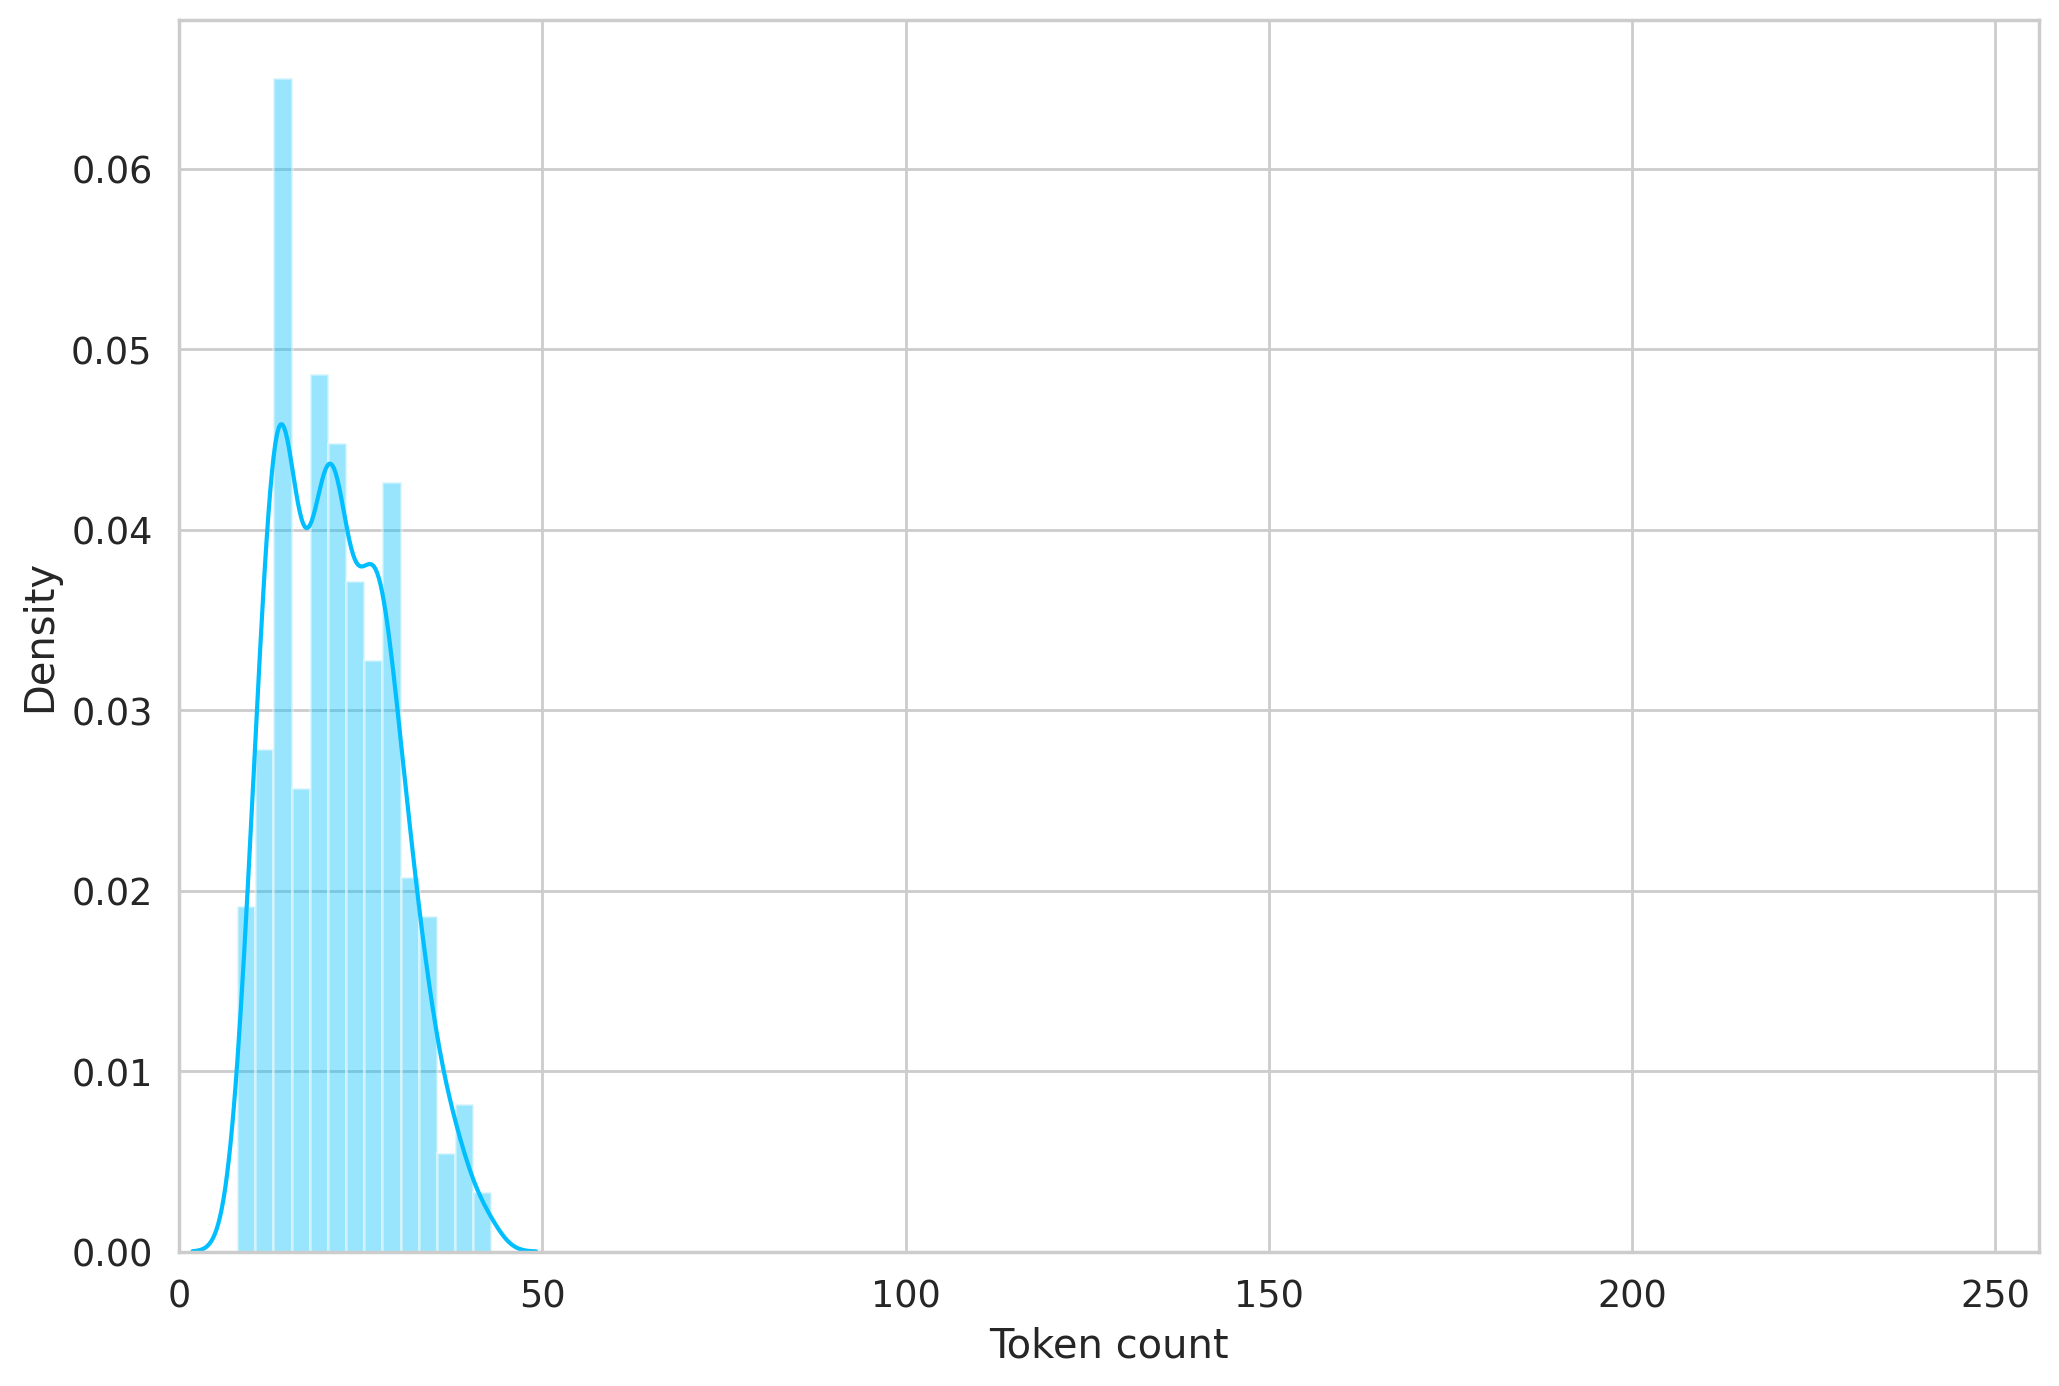

In [24]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [25]:
selected_columns = ['Text', 'Sentiment']
df = df[selected_columns]

In [26]:
MAX_LEN = 50

In [27]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [28]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [29]:
df_train.shape, df_val.shape, df_test.shape

((512, 2), (110, 2), (110, 2))

In [30]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [31]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [33]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


In [34]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [35]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [36]:
PRE_TRAINED_MODEL_NAME

'bert-base-cased'

In [37]:
bert_model.config.hidden_size

768

In [38]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [46]:
model = SentimentClassifier(7)
model = model.to(device)

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 50])
torch.Size([8, 50])


In [48]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1453, 0.1183, 0.2368, 0.0755, 0.2121, 0.0867, 0.1254],
        [0.1197, 0.1384, 0.2295, 0.0607, 0.1637, 0.1483, 0.1396],
        [0.1763, 0.0865, 0.2724, 0.1358, 0.1338, 0.1169, 0.0784],
        [0.0923, 0.1333, 0.3957, 0.0792, 0.0959, 0.0930, 0.1106],
        [0.2564, 0.0512, 0.1596, 0.0819, 0.1497, 0.1430, 0.1582],
        [0.1798, 0.1262, 0.1960, 0.0737, 0.1306, 0.1015, 0.1923],
        [0.1053, 0.1141, 0.3898, 0.0603, 0.1417, 0.0990, 0.0897],
        [0.2732, 0.0834, 0.2385, 0.0426, 0.1741, 0.0956, 0.0926]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [49]:
EPOCHS = 25

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [50]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Update tqdm description with the current loss
    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)


In [51]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [52]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 14.42batch/s, loss=0.966]


Train loss 0.9656467650493141 accuracy 0.71484375


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.41batch/s, loss=0.701]


Val   loss 0.7008414428148951 accuracy 0.7909090909090909

Epoch 2/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.21batch/s, loss=0.616]


Train loss 0.6162508830893785 accuracy 0.802734375


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.12batch/s, loss=0.705]


Val   loss 0.7048009475693107 accuracy 0.7818181818181817

Epoch 3/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.25batch/s, loss=0.427]


Train loss 0.42669389821821824 accuracy 0.849609375


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.14batch/s, loss=0.899]


Val   loss 0.8994862282249544 accuracy 0.7999999999999999

Epoch 4/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.15batch/s, loss=0.304]


Train loss 0.30418692818238924 accuracy 0.888671875


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.57batch/s, loss=0.655]


Val   loss 0.6548775753804615 accuracy 0.8636363636363636

Epoch 5/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.18batch/s, loss=0.249]


Train loss 0.24898378831676382 accuracy 0.91796875


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.26batch/s, loss=0.733]


Val   loss 0.7332401493830341 accuracy 0.8363636363636363

Epoch 6/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.10batch/s, loss=0.178]


Train loss 0.17750596439145738 accuracy 0.9375


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.20batch/s, loss=0.757]


Val   loss 0.7574601114860603 accuracy 0.8818181818181817

Epoch 7/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.11batch/s, loss=0.0893]


Train loss 0.08929016019010305 accuracy 0.974609375


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.08batch/s, loss=0.781]


Val   loss 0.7814812160837131 accuracy 0.8363636363636363

Epoch 8/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.25batch/s, loss=0.05]  


Train loss 0.04997493320297508 accuracy 0.98828125


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.16batch/s, loss=0.845] 


Val   loss 0.8454959496573012 accuracy 0.8545454545454545

Epoch 9/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.24batch/s, loss=0.0252] 


Train loss 0.025205223429111356 accuracy 0.99609375


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 29.53batch/s, loss=0.806]


Val   loss 0.8056986386738052 accuracy 0.8727272727272727

Epoch 10/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.20batch/s, loss=0.00873]


Train loss 0.008734627745525358 accuracy 0.998046875


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.34batch/s, loss=0.897]


Val   loss 0.8969396853935905 accuracy 0.8727272727272727

Epoch 11/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.21batch/s, loss=0.00369]


Train loss 0.0036859593642475375 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.46batch/s, loss=0.892]


Val   loss 0.8918379917636879 accuracy 0.8727272727272727

Epoch 12/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.17batch/s, loss=0.00279]


Train loss 0.0027897252080038015 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 29.99batch/s, loss=0.913]


Val   loss 0.9132159539232296 accuracy 0.8727272727272727

Epoch 13/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.09batch/s, loss=0.00176]


Train loss 0.0017620879452806548 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.59batch/s, loss=0.886]


Val   loss 0.8856040279185565 accuracy 0.8727272727272727

Epoch 14/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.15batch/s, loss=0.00162]


Train loss 0.0016219629719671502 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.94batch/s, loss=0.953]


Val   loss 0.9532250217307592 accuracy 0.8727272727272727

Epoch 15/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.26batch/s, loss=0.00148]


Train loss 0.0014774493911318132 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.69batch/s, loss=0.951]


Val   loss 0.9510353370819108 accuracy 0.8727272727272727

Epoch 16/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.20batch/s, loss=0.00131]


Train loss 0.0013146247176791803 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.17batch/s, loss=0.922]


Val   loss 0.9222862626151515 accuracy 0.8727272727272727

Epoch 17/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.25batch/s, loss=0.00118]


Train loss 0.0011769758655191254 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.13batch/s, loss=0.974]  


Val   loss 0.9742355986028477 accuracy 0.8727272727272727

Epoch 18/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.10batch/s, loss=0.00114] 


Train loss 0.001138323492341442 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.73batch/s, loss=0.928]


Val   loss 0.9282629613371682 accuracy 0.8727272727272727

Epoch 19/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.15batch/s, loss=0.00116] 


Train loss 0.0011605073564169288 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 29.66batch/s, loss=0.956]


Val   loss 0.9557105971408808 accuracy 0.8727272727272727

Epoch 20/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.18batch/s, loss=0.00104]


Train loss 0.0010374753621817945 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.63batch/s, loss=0.966]  


Val   loss 0.9655616310202666 accuracy 0.8636363636363636

Epoch 21/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.26batch/s, loss=0.000995]


Train loss 0.000994791544144391 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.62batch/s, loss=0.944]


Val   loss 0.9437007001605318 accuracy 0.8636363636363636

Epoch 22/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.14batch/s, loss=0.00097] 


Train loss 0.0009700753755623737 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.49batch/s, loss=0.944]


Val   loss 0.9442667452370058 accuracy 0.8636363636363636

Epoch 23/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.25batch/s, loss=0.000964]


Train loss 0.0009637476516672905 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.92batch/s, loss=0.95]


Val   loss 0.9502987664054672 accuracy 0.8636363636363636

Epoch 24/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.18batch/s, loss=0.000918]


Train loss 0.0009175417767437466 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.41batch/s, loss=0.948]


Val   loss 0.9481220988288571 accuracy 0.8636363636363636

Epoch 25/25
----------


Training: 100%|██████████| 64/64 [00:04<00:00, 15.24batch/s, loss=0.000938]


Train loss 0.0009378305669542897 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.28batch/s, loss=0.966]  

Val   loss 0.9659818529351989 accuracy 0.8636363636363636

CPU times: user 1min 47s, sys: 8.63 s, total: 1min 55s
Wall time: 2min 1s


In [53]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [54]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 24.72batch/s, loss=0.902]


0.8363636363636363